In [1]:
# Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset

import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

from CustomCNNVessel import CustomResNet

torch.cuda.empty_cache()

In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.pairs = self._find_pairs(image_dir, mask_dir)

    def _find_pairs(self, image_dir, mask_dir):
        pairs = []
        for img_file in os.listdir(image_dir):
            base_name = os.path.splitext(img_file)[0]
            mask_file = os.path.join(mask_dir, base_name + '.png')
            if os.path.exists(mask_file):
                pairs.append(img_file)
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_file = self.pairs[idx]
        image_path = os.path.join(self.image_dir, img_file)
        base_name = os.path.splitext(img_file)[0]
        mask_path = os.path.join(self.mask_dir, base_name + '.png')

        image = Image.open(image_path) # TODO: REMOVE CONVERT, IMAGES ARE ONE CHANNEL
        mask = Image.open(mask_path)# REMOVE

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((448, 448)),
]) #TODO: center crop instead of resize, add color channel

# Paths to your image and mask directories
image_dir = "./data/images/"
mask_dir = './data/labels/'

# Create the dataset
dataset = SegmentationDataset(image_dir, mask_dir, transform)


# Create a DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)

Total number of batches: 133


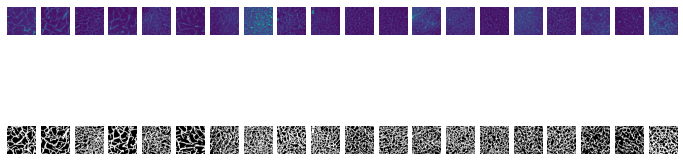

In [3]:
num_batches = len(dataloader)
print("Total number of batches:", num_batches)


# Iterate over the first few batches
for i, (images, masks) in enumerate(dataloader):
    if i >= 1:  # Display only the first batch
        break
    # Display images and masks
    fig, axs = plt.subplots(2, len(images), figsize=(12, 4))
    for j in range(len(images)):
        axs[0, j].imshow(images[j].permute(1, 2, 0))  # Assuming images are in (C, H, W) format
        axs[1, j].imshow(masks[j][0], cmap='gray')    # Assuming masks are in (C, H, W) format and C=1
        axs[0, j].axis('off')
        axs[1, j].axis('off')
    plt.show()

In [4]:
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)  # e.g., 80% for training
val_size = dataset_size - train_size

# Split the dataset
train_dataset, train_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)

In [5]:
# Placeholders for metrics
train_losses = []
test_losses = []
test_accuracies = []

# Defining IOU to use as metric
def iou_metric(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

In [6]:
# Model Initialization
model = CustomResNet(num_classes=2).cuda() 

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)


# Training loop
num_epochs = 30
train_losses = []
test_losses = []
test_ious = []

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()  # .cuda() if using GPU
        labels = labels.squeeze(1).long()  # Adjusting the shape of labels for CrossEntropyLoss

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:  # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    
    # Calculate training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validate the model
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            labels = labels.squeeze(1).long()  # Adjusting the shape of labels for CrossEntropyLoss
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_iou += iou_metric(labels.float(), predicted.float())
    
    avg_test_loss = test_loss / len(test_loader)
    scheduler.step(avg_test_loss)
    
    avg_iou = total_iou / len(test_loader)
    test_ious.append(avg_iou.cpu())

    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Test Loss: {avg_test_loss:.4f} Test IoU: {avg_iou:.4f}')

Epoch [1/30] Train Loss: 0.3093 Test Loss: 0.4638 Test IoU: 0.6193
Epoch [2/30] Train Loss: 0.2188 Test Loss: 0.2053 Test IoU: 0.8102
Epoch [3/30] Train Loss: 0.1996 Test Loss: 0.1858 Test IoU: 0.8222
Epoch [4/30] Train Loss: 0.1890 Test Loss: 0.1866 Test IoU: 0.8190
Epoch [5/30] Train Loss: 0.1880 Test Loss: 0.1890 Test IoU: 0.8214
Epoch [6/30] Train Loss: 0.1810 Test Loss: 0.2270 Test IoU: 0.7913
Epoch [7/30] Train Loss: 0.1896 Test Loss: 0.2431 Test IoU: 0.7934
Epoch [8/30] Train Loss: 0.1916 Test Loss: 0.2232 Test IoU: 0.7920
Epoch [9/30] Train Loss: 0.1771 Test Loss: 0.1823 Test IoU: 0.8242
Epoch [10/30] Train Loss: 0.1762 Test Loss: 0.1842 Test IoU: 0.8279
Epoch [11/30] Train Loss: 0.1722 Test Loss: 0.2041 Test IoU: 0.8150
Epoch [12/30] Train Loss: 0.1838 Test Loss: 0.1930 Test IoU: 0.8245
Epoch [13/30] Train Loss: 0.1684 Test Loss: 0.1687 Test IoU: 0.8374
Epoch [14/30] Train Loss: 0.1808 Test Loss: 0.1984 Test IoU: 0.8151
Epoch [15/30] Train Loss: 0.1981 Test Loss: 0.2639 Test I

In [7]:
# Saving model
torch.save(model.state_dict(), f'./Models/custom_cnn_vessel.pth')

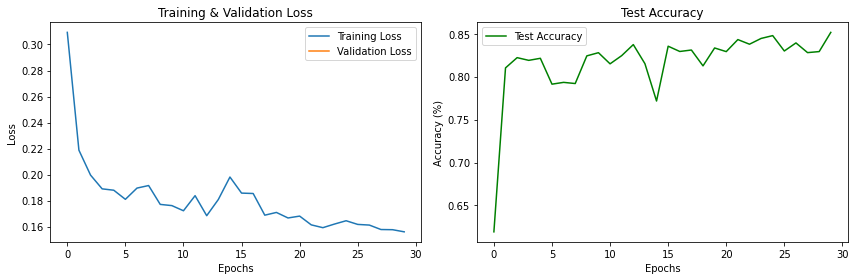

In [8]:
# 4. Plotting metrics
plt.figure(figsize=(12, 4))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
_ = plt.legend()

# Test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_ious, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
_ = plt.legend()

_ = plt.tight_layout()
_ = plt.show()

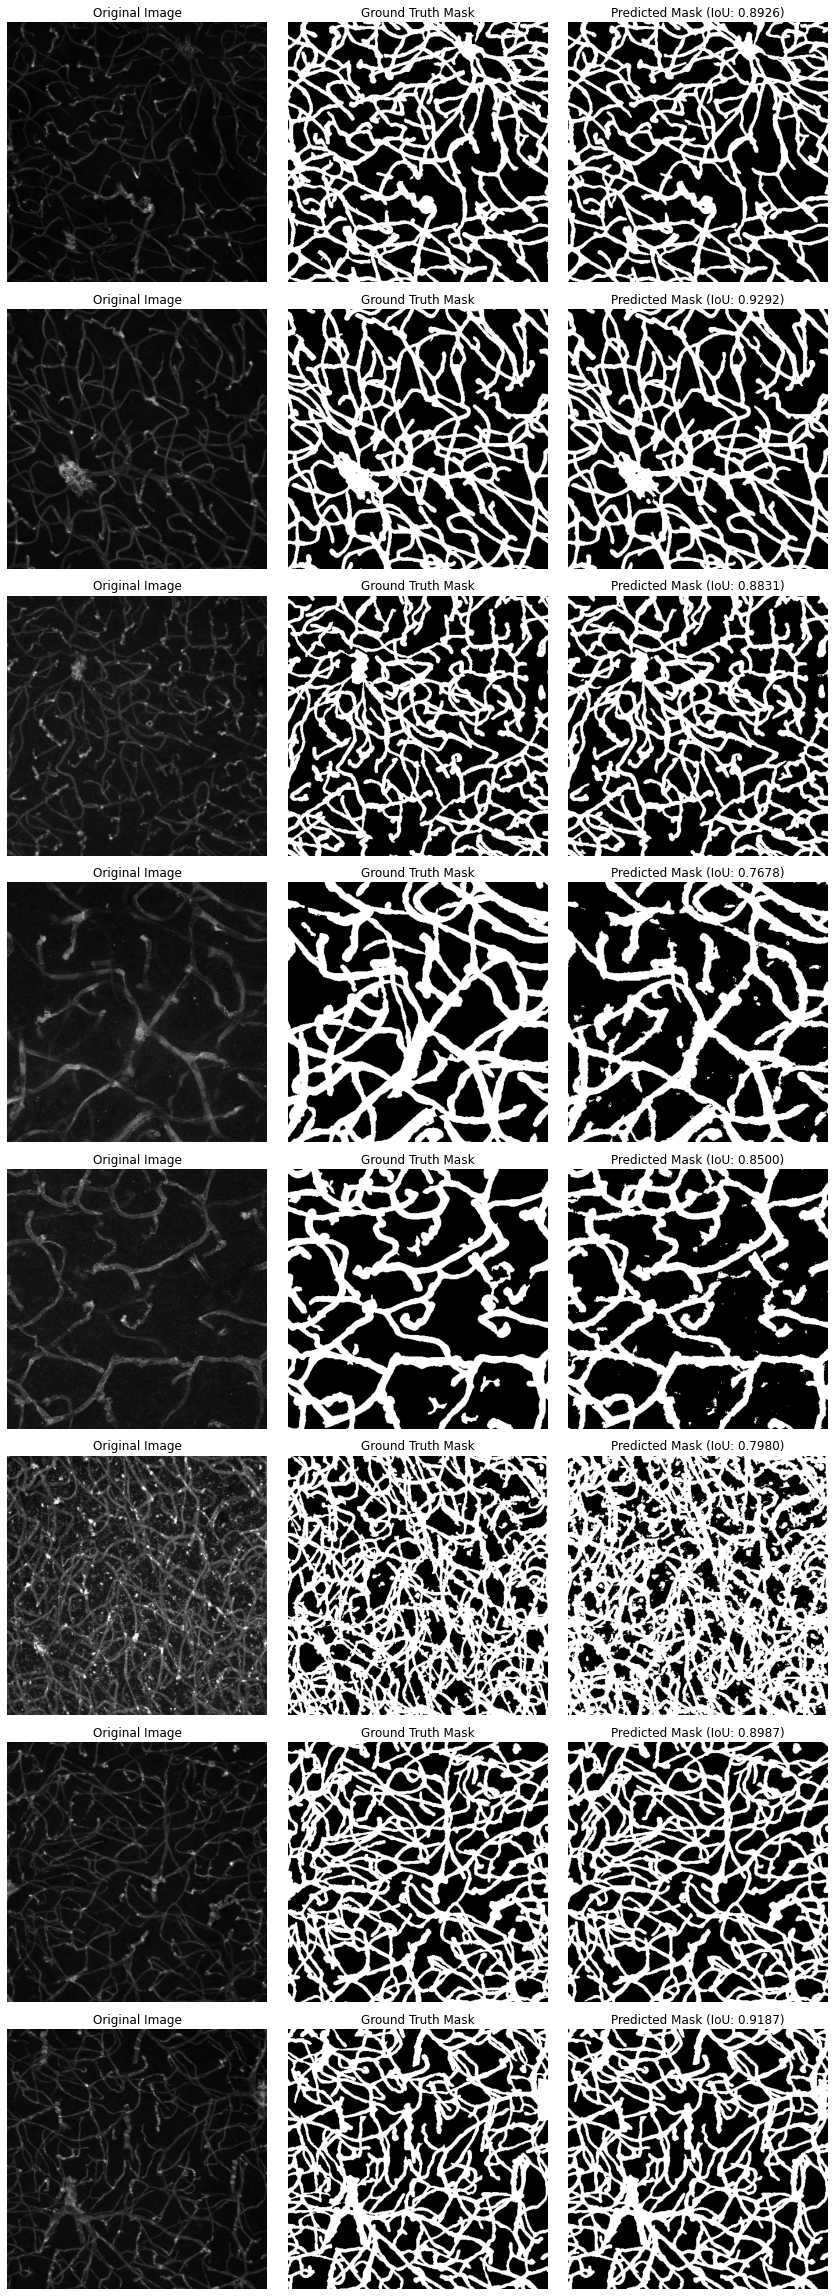

In [10]:
model.cpu().eval()

# Select a random batch from the test dataset
images, masks = next(iter(test_loader))
if torch.cuda.is_available():
    images, masks = images, masks

# Get model predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Plot the results
fig, axs = plt.subplots(len(images), 3, figsize=(12, len(images)*4))
for idx, (img, mask, pred) in enumerate(zip(images, masks, preds)):
    mask_np = mask.squeeze().cpu().numpy()
    pred_np = pred.squeeze().cpu().numpy()
    
    iou_score = iou_metric(mask_np, pred_np)
    
    
    axs[idx, 0].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axs[idx, 0].set_title('Original Image')
    
    axs[idx, 1].imshow(mask_np, cmap='gray')
    axs[idx, 1].set_title('Ground Truth Mask')
    
    axs[idx, 2].imshow(pred_np, cmap='gray')
    axs[idx, 2].set_title(f'Predicted Mask (IoU: {iou_score:.4f})')

for ax in axs.ravel():
    ax.axis('off')

plt.tight_layout()
plt.show()